# Importamos las librerías importantes

In [53]:
import struct
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.fft import fft, fftshift

# Comenzamos el código para el archivo "muestras_88_9.bin"

In [54]:
#Lo que deben realizar es escoger uno de los archivos “muestras_XXXMHz.bin” y analizar el espectro
#de las muestras capturadas y obtener el audio de cada una de las estaciones en el archivo de muestras elegido. 
data_bin = open('muestras_88_9.bin', 'rb');
data_array = np.fromfile(data_bin, 'int8')

#I +j*Q, I parte real, Q parte imaginaria.
señal_,I,Q = [],[],[]

for i in range(0,len(data_array)-1,2):
    I.append(data_array[i])
    Q.append(data_array[i+1])
    señal_.append(data_array[i]+1j*data_array[i+1])
I=np.array(I)
Q=np.array(Q)

In [55]:
señal=np.array(señal_)

In [56]:
"""Una muestra del espectro se almacena como dos componentes: una es la componente en fase
(I) y la otra es la componente en cuadratura (Q).
 Cada componente es de 8 bits y están representadas como signed ints.
 Las muestras están concatenadas, es decir, la n-ésima muestra de la componente en fase (8
bits) es seguida por la n-ésima muestra de la componente en cuadratura (8 bits), lo cual da que
la muestra total (ambas componentes) es de 16 bits.
#qq se refiere que lee 2 enteros de 8 bits cada uno.
print(int(len(data)/16))
señal= []
for i in range(int(len(data)/16)):
    I,Q=struct.unpack("@qq", data[16*i:16*(i+1)])
    # the complex data is  y = I + jQ.
    señal.append(I+1j*Q)
"""
señal[0:5]

array([-74.-119.j, -34. -10.j, -76. +79.j, -10. -80.j, -70.+105.j])

Text(0.5, 0, 'Frequency [Hz]')

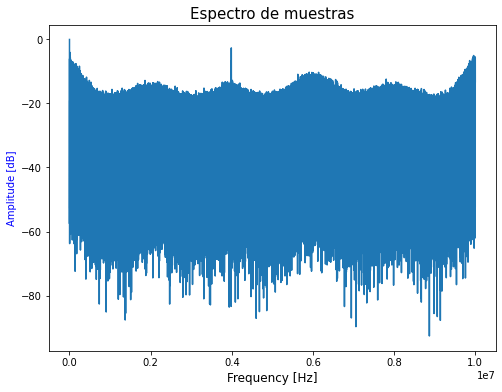

In [57]:
espectro = np.abs(fft(señal))
Espectro_normalizado=espectro/max(espectro);

plt.figure(figsize=(8, 6))
plt.plot(20. * np.log10(Espectro_normalizado));

plt.title('Espectro de muestras',fontsize=15)
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]',fontsize=12)

In [58]:
!sudo apt-get install libportaudio2
!pip install sounddevice

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [59]:
import soundfile as sf
import sounddevice as sd

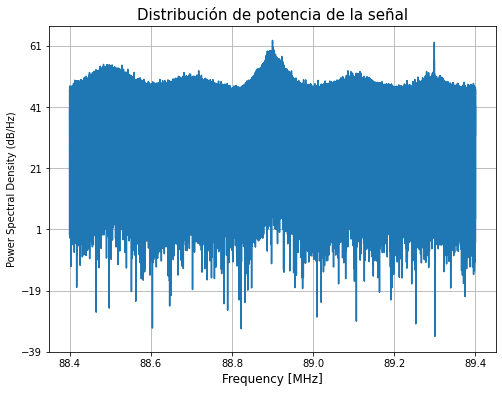

In [60]:
Fc = 88.9*(10**6) #Frecuencia central [Hz]
Fs = 10**6 #Frecuencia de muestreo [Hz]
"""
Encontramos la Densidad Espectral de Potencia, 
que nos entrega la distribución de la potencia de la señal
sobre las frecuencias que la forman
"""
plt.figure(figsize=(8, 6))
plt.psd(señal,NFFT=10**7,Fs=Fs/1e6,Fc=Fc/1e6)
plt.title('Distribución de potencia de la señal',fontsize=15)
plt.xlabel('Frequency [MHz]',fontsize=12)
plt.show()

In [61]:
# Pasamos a banda base
car = np.exp(-1.0j*2.0*np.pi/Fs*np.arange(0,len(señal),1))
base = señal*np.transpose(car)

In [62]:
def FFT_Centrada(senal,n0,nf,fs,fc):
  # senal: la señal de la cual queremos observar su espectro.
  # n0: muestra inicial
  # nf: muestra final
  # fs: tasa o frecuencia de muestreo en MHz
  # fc: frecuencia de corte en MHz
  segmento = senal[n0:(n0+nf-1)] # Tomamos un trozo de la señal
  espectro = fftshift(fft(segmento)) # calculamos la FFT del segmento seleccionado
  z = 20*np.log10(abs(espectro)/max(abs(espectro))) # Encontramos la amplitud normalizada para el espectro encontrado
  Lf = fc-fs/2 # Límite inferior de la frecuencia
  Hf = fc+fs/2 # Límite superior de la frecuencia
  n = len(z) # largo del vector encontrado para la amplitud
  freq = np.arange(0,n,1)*fs/n+Lf # Permite crear el vector de frecuencias colocando el centro en la frecuencia de corte fc
  plt.figure(figsize=(8, 6))
  plt.plot(freq,z) # Graficamos
  plt.axvspan(fc,fc, color='red',alpha=1) # Marca la línea en la frecuencia de corte
  """
  Definimos ejes
  """
  
  plt.title('Espectro de frecuencia centrado en '+str(fc)+'[MHz]',fontsize=15)
  plt.xlabel('Frecuencia [MHz]',fontsize=12)
  plt.ylabel('Amplitud Relativa',fontsize=12)

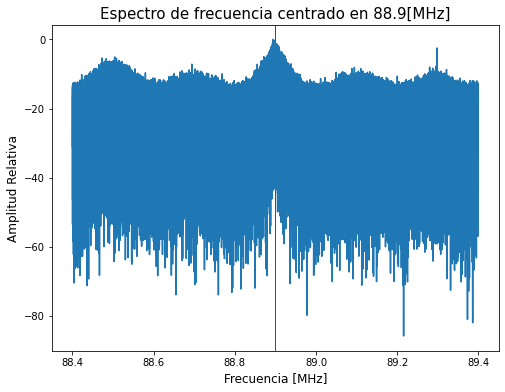

In [63]:
"""
Observamos el Espectro de la señal centrado
"""
FFT_Centrada(base,0,2*10**6,1,88.9)


De aquí en adelante falta arreglar

In [64]:
"""
Definimos la función para demodular la señal 
"""
def Ydem(senal):
  b = signal.firls(31,[0, 0.9],[0, 1], )
  d = senal/abs(senal)
  rd = d.real
  id = d.imag
  return (rd*np.convolve(id,b,'same') - id*np.convolve(rd,b,'same'))/(rd**2+id**2)

In [65]:
dem = Ydem(base)
df = signal.decimate(dem,10,ftype='fir')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [66]:
base,dem,df

(array([-74.        -119.j        , -34.00006283  -9.99978637j,
        -75.99900725 +79.00095504j, ...,  58.00041468 -21.99890672j,
         48.99870566+103.00061574j, 117.00029531 -46.99926487j]),
 array([ 0.15666459,  0.07183906, -0.37866586, ..., -0.44204072,
         0.47488098, -0.25156428]),
 array([ 0.0046796 ,  0.00154064,  0.00209347, ...,  0.00453001,
        -0.00551721, -0.00195115]))

In [67]:
len(base),len(dem),len(df)

(10000000, 10000000, 1000000)

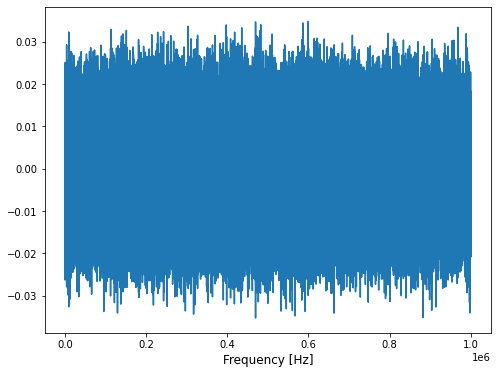

In [68]:
plt.figure(figsize=(8, 6))
plt.plot(df)


plt.xlabel('Frequency [Hz]',fontsize=12)
plt.show()

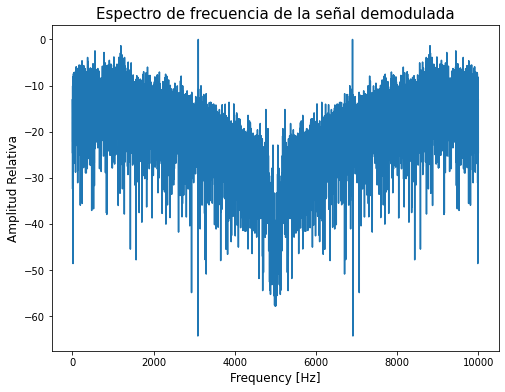

In [69]:
segmento = df[0:(10000-1)] # Tomamos un trozo de la señal
espectro = fftshift(fft(segmento)) # calculamos la FFT del segmento seleccionado
z = 20*np.log10( abs(espectro)/max(abs(espectro) ))

plt.figure(figsize=(8, 6))
plt.plot(z)

plt.title('Espectro de frecuencia de la señal demodulada',fontsize=15)
plt.xlabel('Frequency [Hz]',fontsize=12)
plt.ylabel('Amplitud Relativa',fontsize=12)
plt.show()

In [70]:
#sd.play(df.astype('int16'),Fs,blocking=True)

# Se comienza con el código para el archivo "muestras_TV.bin"

In [71]:
data_bin_TV = open('muestras_TV.bin', 'rb');
data_array_TV = np.fromfile(data_bin_TV, 'int8')

#I +j*Q, I parte real, Q parte imaginaria.
señalTV_,I_TV,Q_TV = [],[],[]

for i in range(0,len(data_array)-1,2):
    I_TV.append(data_array_TV[i])
    Q_TV.append(data_array_TV[i+1])
    señalTV_.append(data_array_TV[i]+1j*data_array_TV[i+1])
I_TV=np.array(I_TV)
Q_TV=np.array(Q_TV)

In [72]:
señal_TV=np.array(señalTV_)

In [73]:
car_TV = np.exp(-1.0j*2.0*np.pi/Fs*np.arange(0,len(señal_TV),1))
base_TV = señal_TV*np.transpose(car_TV)

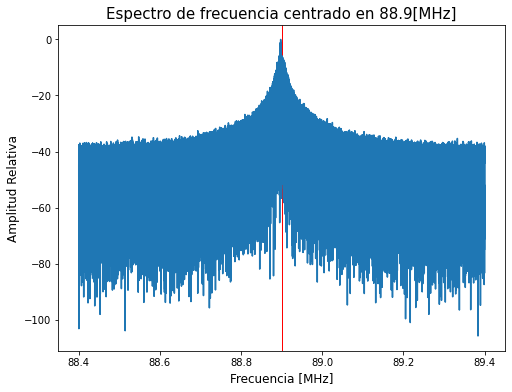

In [74]:
FFT_Centrada(base_TV,0,2*10**6,1,88.9)

In [75]:
dem_TV = Ydem(base_TV)
df_TV = signal.decimate(dem_TV,10,ftype='fir')

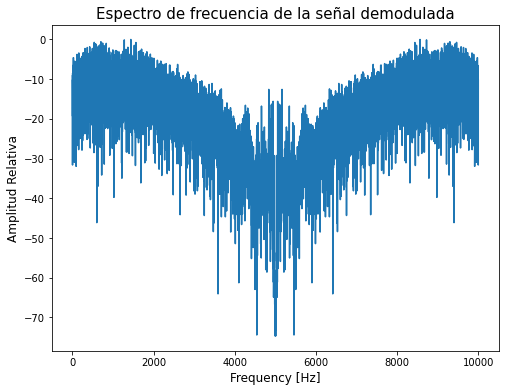

In [76]:
segmento_TV = df_TV[0:(10000-1)] # Tomamos un trozo de la señal
espectro_TV = fftshift(fft(segmento_TV)) # calculamos la FFT del segmento seleccionado
z_TV = 20*np.log10( abs(espectro_TV)/max(abs(espectro_TV) ))

plt.figure(figsize=(8, 6))
plt.plot(z_TV)

plt.title('Espectro de frecuencia de la señal demodulada',fontsize=15)
plt.xlabel('Frequency [Hz]',fontsize=12)
plt.ylabel('Amplitud Relativa',fontsize=12)
plt.show()